# Example: PyRayHF Cartesian Gradient Raytracing with PyIRI Data

This is a modification of [`Example_PyRayHF_Cartesian_Gradient.ipynb`](./Example_PyRayHF_Cartesian_Gradient.ipynb) that simply demonstrates the process of ray tracing on input data obtained from PyIRI.

(see [`Example_Generate_2D_Input.ipynb`](./Example_Generate_2D_Input.ipynb) for generating PyIRI input data for PyRayHF)

1. Imports

In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_refractive_index_interpolator_cartesian
from PyRayHF.library import trace_ray_cartesian_gradient
from PyRayHF.library import build_mup_function
import time

2. Load Previously Generated PyIRI Data

In [2]:
# Load ionospheric data
file_open = 'Example_input_2D.p'
input_arrays = pickle.load(open(file_open, 'rb'))

# Extract Data
z_grid = input_arrays["zgrid"]
x_grid = input_arrays["xgrid"]
den = input_arrays["den"]
bmag = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

3. Set Ray Parameters

In [3]:
# Ray Parameters
elevation_deg = 50. # Transmitted ray elevation angle in degrees
f0_Hz = 8e6 # Transmitted ray frequency in Hz
mode = "O" # Transmitted ray mode (O or X)

4. Perform Raytracing

In [4]:
# Start the timer
start_time = time.perf_counter()

# Calculate plasma parameters
X = find_X(den, f0_Hz)
Y = find_Y(f0_Hz, bmag)

mu, mup = find_mu_mup(X, Y, bpsi, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

# Build interpolator from mup grid
n_and_grad_cart = build_refractive_index_interpolator_cartesian(z_grid, x_grid, mu)

# Build μ' (group) for delay only
mup_func_cart = build_mup_function(mup_field=mup,
                                   x_grid=x_grid,
                                   z_grid=z_grid,
                                   geometry="cartesian")

# Ray trace
result = trace_ray_cartesian_gradient(n_and_grad=n_and_grad_cart,
                                      x0_km=0.0,
                                      z0_km=0.0,
                                      elevation_deg=elevation_deg,
                                      s_max_km=4000.0,
                                      max_step_km=5.0,
                                      z_max_km=600.0,
                                      x_min_km=0.0,
                                      x_max_km=1000.0,
                                      mup_func=mup_func_cart)

# Stop the timer
end_time = time.perf_counter()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

5. Plot the Results

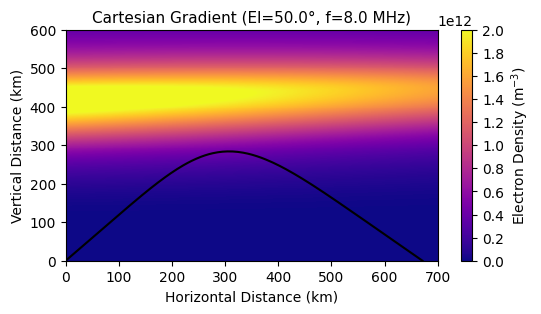

--------------------------------------------------
Gradient-based raytracing in a medium with gradient:
--------------------------------------------------
Group Path (km):  896.6769976698855
Group delay (sec):  0.003276827940594032
Ground_ Range (km):  671.4091585747444
x midpoint (km):  342.93992951695793
z midpoint (km):  278.05998491913243
--------------------------------------------------
Elapsed time (sec):  0.3273637816309929
--------------------------------------------------


In [7]:
# Plot results
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 3)
ax_plot = ax
ax_plot.set_xlim(0, 700)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
vmin = 0
vmax = 2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
Xg, Zg = np.meshgrid(x_grid, z_grid)
pc = ax_plot.pcolormesh(Xg, Zg, den, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.plot(result['x'], result['z'], c='black')
ax_plot.set_title(f"Cartesian Gradient (El={elevation_deg:.1f}°, f={f0_Hz/1e6} MHz)", fontsize=11)
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax_plot,
             ticks=color_ticks)
plt.savefig('../figures/Cartesian_Gradient_PyIRI.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
 
# Print diagnostics
print('--------------------------------------------------')
print('Gradient-based raytracing in a medium with gradient:')
print('--------------------------------------------------')
print('Group Path (km): ', result['group_path_km'])
print('Group delay (sec): ', result['group_delay_sec'])
print('Ground_ Range (km): ', result['ground_range_km'])
print('x midpoint (km): ', result['x_midpoint'])
print('z midpoint (km): ', result['z_midpoint'])

print('--------------------------------------------------')
print('Elapsed time (sec): ', elapsed_time)
print('--------------------------------------------------')